# NEKA - 2023-2024
The objective is to say if a driver is tired or not, to avoid car accidents. The idea of this file is to preprocess face images to generate a model which is able to predict drowsiness.

## 1 Imports

In [61]:
from matplotlib import pyplot as plt
import os
import numpy as np
import cv2
import tensorflow as tf
import shutil
# --- keras ---
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, AUC
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import clone_model
# --- sklearn ---
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

## 2 Global Constant Variables
These constants will be used during the whole dataset, making the development cleaner and easier.

In [2]:
RANDOM_SEED = 42
CLASS_NAMES = ('Awake', 'Tired')
EPOCHS = 10
BATCH_SIZE = 32

## 3 Global Utils
These functions will be used during the whole dataset, making the development cleaner and easier.

### 3.1 Save Data

In [3]:
def create_class_folders(output_dir, classes):
    for class_name in classes:
        class_path = os.path.join(output_dir, class_name)

        # Check if the folder already exists
        if os.path.exists(class_path):
            # If it exists, delete it and its contents
            shutil.rmtree(class_path)

        # Create the folder
        os.makedirs(class_path, exist_ok=True)

# Function to save images from a dataset to class-specific folders
def save_images(X, y, output_dir, classes):
    create_class_folders(output_dir, classes)

    # Save the images to the specified folder
    for i, (img, label) in enumerate(zip(X, y)):
        class_path = os.path.join(output_dir, label)
        filename = f'image_{len(os.listdir(class_path)) + 1}.png'
        filepath = os.path.join(class_path, filename)
        
        # Save the image
        cv2.imwrite(filepath, img)

### 3.2 Plot Images

In [4]:
def plot_line_of_images(X, y, n_images):
    fig, ax = plt.subplots(ncols=n_images, figsize=(20, 20))
    for idx, img in enumerate(X[:n_images]):
        ax[idx].imshow(img.astype(int))
        ax[idx].title.set_text(f"Label: {y[idx]}")
        
def plot_desired_images(X, y, indexes):
    fig, ax = plt.subplots(ncols=len(indexes), figsize=(20, 20))
    for idx, img in enumerate(X[indexes]):
        ax[idx].imshow(img.astype(int))
        ax[idx].title.set_text(f"Label: {y[indexes[idx]]}")    

### 3.3 Data Manipulation

In [5]:
def move_images_from_one_to_other(X1,y1, X2, y2, n):
    # Specify the indices of images you want to move from array1 to array2
    indices_to_move = np.random.choice(X1.shape[0], n)
    
    # Extract the selected images from array1
    selected_images = X1[indices_to_move]
    selected_labels = y1[indices_to_move]
    
    # Remove the selected images from array1
    X1 = np.delete(X1, indices_to_move, axis=0)
    y1 = np.delete(y1, indices_to_move, axis=0)
    
    # Concatenate the selected images to array2
    X2 = np.concatenate((X2, selected_images), axis=0)
    y2 = np.concatenate((y2, selected_labels), axis=0)
    
    # Print the shapes of the arrays after moving images
    print("X1 Shape after Moving:", X1.shape)
    print("y1 Shape after Moving:", y1.shape)
    print("X2 Shape after Moving:", X2.shape)
    print("y2 Shape after Moving:", y2.shape)
    
    return X1, y1, X2, y2

## 4 Load Data
The data that will be used to create CNN capable to detect drowsiness levels will be uploaded during the following cells.

### 4.1 Load Data Constant Variables

In [6]:
DIR_KAGGLE_RAW_DATA_TIRED = '../data/raw/FaceImages/Tired'
DIR_KAGGLE_RAW_DATA_AWAKE = '../data/raw/FaceImages/Awake'

DIR_OUR_RAW_DATA_TIRED = '../data/raw/OurDataset/Tired'
DIR_OUR_RAW_DATA_AWAKE = '../data/raw/OurDataset/Awake'

RAW_IMAGE_SIZE = (256, 256)

### 4.2 Load Data Utils

In [8]:
def load_images_from_folder(folder, resize):
    images = []
    labels = []
    
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        label = folder.split("/")[-1]  # Extract class label from folder name
        
        if os.path.isfile(path):
            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, resize)
            
            images.append(img)
            labels.append(label)
    
    return np.array(images), np.array(labels)

### 4.3 Finally Load Data
The data that will be used to create CNN capable to detect drowsiness levels will be uploaded during the following cells.

#### 4.3.1 Load Kaggle Data
This data will be used to train the base CNN. Afterwards, using the data the team gathered Transfer Learning will be applied.

In [9]:
X_tired_kaggle_raw, y_tired_kaggle_raw = load_images_from_folder(DIR_KAGGLE_RAW_DATA_TIRED, RAW_IMAGE_SIZE)
X_awake_kaggle_raw, y_awake_kaggle_raw = load_images_from_folder(DIR_KAGGLE_RAW_DATA_AWAKE, RAW_IMAGE_SIZE)

X_kaggle_raw = np.concatenate([X_tired_kaggle_raw, X_awake_kaggle_raw], axis=0)
y_kaggle_raw = np.concatenate([y_tired_kaggle_raw, y_awake_kaggle_raw], axis=0)

X_kaggle_shuffled, y_kaggle_shuffled = shuffle(X_kaggle_raw, y_kaggle_raw, random_state=RANDOM_SEED)

print(f"Loaded images: {X_kaggle_shuffled.shape}")
print(f"Loaded labels: {y_kaggle_shuffled.shape}")

Loaded images: (6797, 256, 256, 3)
Loaded labels: (6797,)


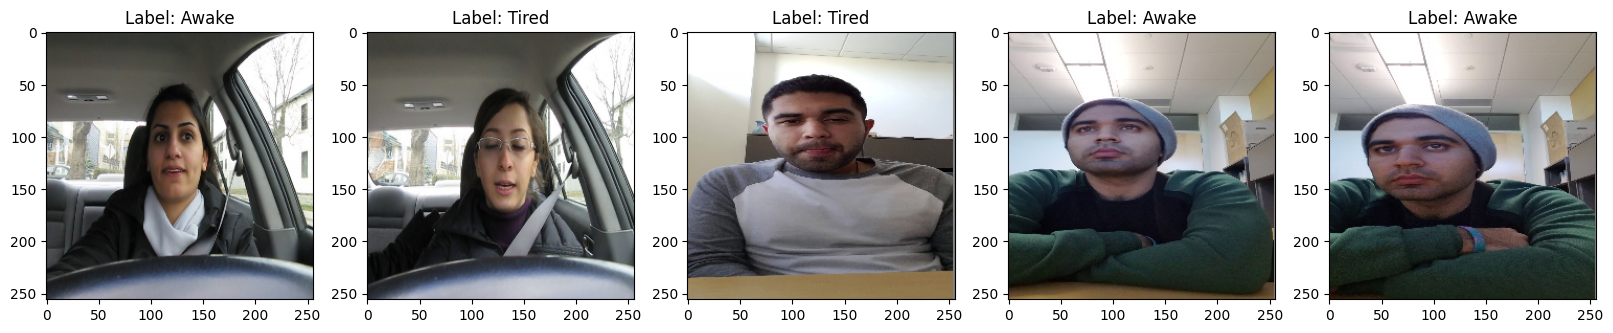

In [10]:
plot_line_of_images(X_kaggle_shuffled, y_kaggle_shuffled, 5)

#### 4.3.2 Load Our Data
This data will be used in order to apply Transfer Learning to the developed model, in order to reach better generalization.
In order to avoid Catastrophic interference, also known as catastrophic forgetting, which is the tendency of an artificial neural network to abruptly and drastically forget previously learned information upon learning new information, some images from the Kaggle dataset will be added to the np array containing our images.

In [11]:
X_tired_our_raw, y_tired_our_raw = load_images_from_folder(DIR_OUR_RAW_DATA_TIRED, RAW_IMAGE_SIZE)
X_awake_our_raw, y_awake_our_raw = load_images_from_folder(DIR_OUR_RAW_DATA_AWAKE, RAW_IMAGE_SIZE)

X_our_raw = np.concatenate([X_tired_our_raw, X_awake_our_raw], axis=0)
y_our_raw = np.concatenate([y_tired_our_raw, y_awake_our_raw], axis=0)

X_our_shuffled, y_our_shuffled = shuffle(X_our_raw, y_our_raw, random_state=RANDOM_SEED)

print(f"Loaded images: {X_our_shuffled.shape}")
print(f"Loaded labels: {y_our_shuffled.shape}")


Loaded images: (3686, 256, 256, 3)
Loaded labels: (3686,)


In [12]:
# Add Kaggle Data to avoid catastrophic forgetting
X_kaggle_shuffled, y_kaggle_shuffled, X_our_shuffled, y_our_shuffled = move_images_from_one_to_other(X_kaggle_shuffled, y_kaggle_shuffled, X_our_shuffled, y_our_shuffled, 1000)

X_our_shuffled, y_our_shuffled = shuffle(X_our_shuffled, y_our_shuffled, random_state=RANDOM_SEED)

X1 Shape after Moving: (5864, 256, 256, 3)
y1 Shape after Moving: (5864,)
X2 Shape after Moving: (4686, 256, 256, 3)
y2 Shape after Moving: (4686,)


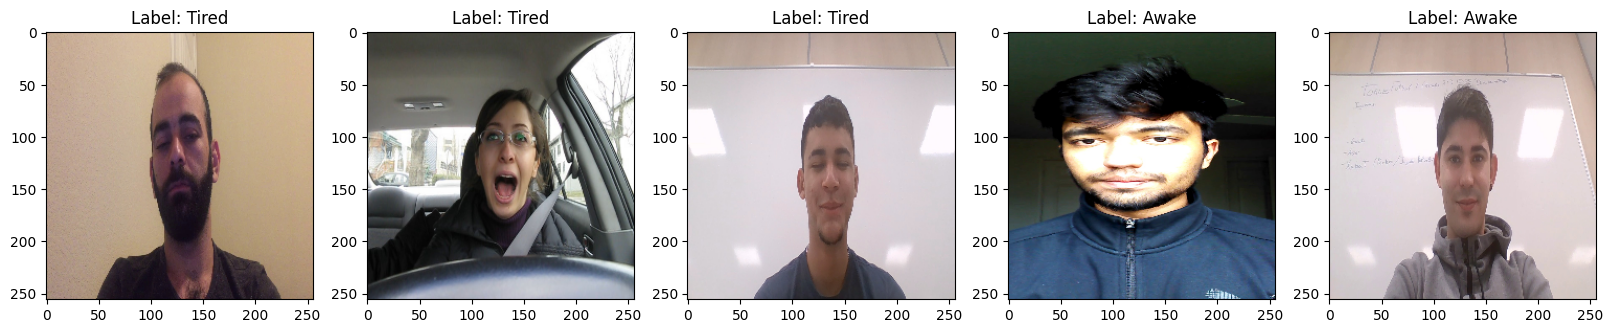

In [13]:
plot_line_of_images(X_our_shuffled, y_our_shuffled, 5)

## 5 Train Test Split
In order to check whether the modelling succeeded (if overfitting didn't occur) a train test split will be made at the beginnig of the process. This way the validation set generated below will be used to simulate unseen data.

### 5.1 Train Test Split Constants

In [14]:
DIR_KAGGLE_TRAIN_DATA = '../data/raw/FaceImagesTrainTest/train'
DIR_KAGGLE_TEST_DATA = '../data/raw/FaceImagesTrainTest/test'

DIR_OUR_TRAIN_DATA = '../data/raw/OurDatasetTrainTest/train'
DIR_OUR_TEST_DATA = '../data/raw/OurDatasetTrainTest/test'

### 5.2 Make Train Test Splits

#### 5.2.1 Kaggle Data Train Test Split

In [15]:
X_kaggle_train, X_kaggle_test, y_kaggle_train, y_kaggle_test = train_test_split(X_kaggle_shuffled, y_kaggle_shuffled, test_size=0.2, random_state=RANDOM_SEED)

In [16]:
# save split
# save_images(X_kaggle_train, y_kaggle_train, DIR_KAGGLE_TRAIN_DATA, CLASS_NAMES)
# save_images(X_kaggle_test, y_kaggle_test, DIR_KAGGLE_TEST_DATA, CLASS_NAMES)

#### 5.2.2 Our Data Train Test Split

In [17]:
X_our_train, X_our_test, y_our_train, y_our_test = train_test_split(X_our_shuffled, y_our_shuffled, test_size=0.2, random_state=RANDOM_SEED)

In [18]:
# save split
# save_images(X_our_train, y_our_train, DIR_OUR_TRAIN_DATA, CLASS_NAMES)
# save_images(X_our_test, y_our_test, DIR_OUR_TEST_DATA, CLASS_NAMES)

#### 5.2.3 Organize Data

In [19]:
X_test = np.concatenate([X_kaggle_test, X_our_test], axis=0)
y_test = np.concatenate([y_kaggle_test, y_our_test], axis=0)

X_test_shuffled, y_test_shuffled = shuffle(X_test, y_test)

## 6 Preprocessing

### 6.1 Haar Cascade Cropping

During this notebook Haar Cascade algorithm will be implemented to crop and preprocess the images that will be used for further model training.

#### 6.1.1 Haar Cascade Constant Variables

In [20]:
DIR_KAGGLE_TRAIN_DATA_CROPPED = '../data/interim/KaggleCropped/'
DIR_OUR_TRAIN_DATA_CROPPED = '../data/interim/OurCropped/'

CROPPED_IMAGE_SIZE = (128, 128)
HAAR_CASCADE_MODEL_PATH = '../models/haarcascade_frontalface_alt2.xml'

#### 6.1.2 Haar Cascade Utils

In [21]:
def load_face_cascade(path):
    face_cascade = cv2.CascadeClassifier(path)
    if face_cascade.empty():
        print("Error loading Haar Cascade classifier.")
    else:
        print("Haar Cascade classifier loaded successfully.")
    return face_cascade

def apply_haar_cascade_on_image(image, face_cascade):
    miscropped = False
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)

    # apply algorithm
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

    if len(faces) > 0:
        # Draw a rectangle around the main face and crop this
        (x, y, w, h) = faces[0]
        # cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        detected_face = image[y:y + h, x:x + w]
    else:
        miscropped = True
        detected_face = image

    return detected_face, miscropped

def apply_haar_cascade_on_images(images, face_cascade):
    cropped_images = np.random.random((images.shape[0], CROPPED_IMAGE_SIZE[0], CROPPED_IMAGE_SIZE[1], 3))
    
    miscropped_images = 0

    for idx, image in enumerate(images):
        detected_face, miscropped = apply_haar_cascade_on_image(image, face_cascade)
        
        cropped_images[idx] = np.array(cv2.resize(detected_face.astype(np.uint8), CROPPED_IMAGE_SIZE))
        
        if miscropped: 
            miscropped_images += 1

    return miscropped_images, cropped_images

#### 6.1.3 Apply Haar Cascade Cropping

##### 6.1.3.1 Apply Haar Cascade Cropping To Kaggle Data

In [22]:
face_cascade = load_face_cascade(HAAR_CASCADE_MODEL_PATH) 
miscropped_kaggle_images, X_kaggle_train_cropped = apply_haar_cascade_on_images(X_kaggle_train, face_cascade)

print("All Test Cropped Images Shape:", X_kaggle_train_cropped.shape)
print("All MisCropped Test Images:", miscropped_kaggle_images)

Haar Cascade classifier loaded successfully.
All Test Cropped Images Shape: (4691, 128, 128, 3)
All MisCropped Test Images: 965


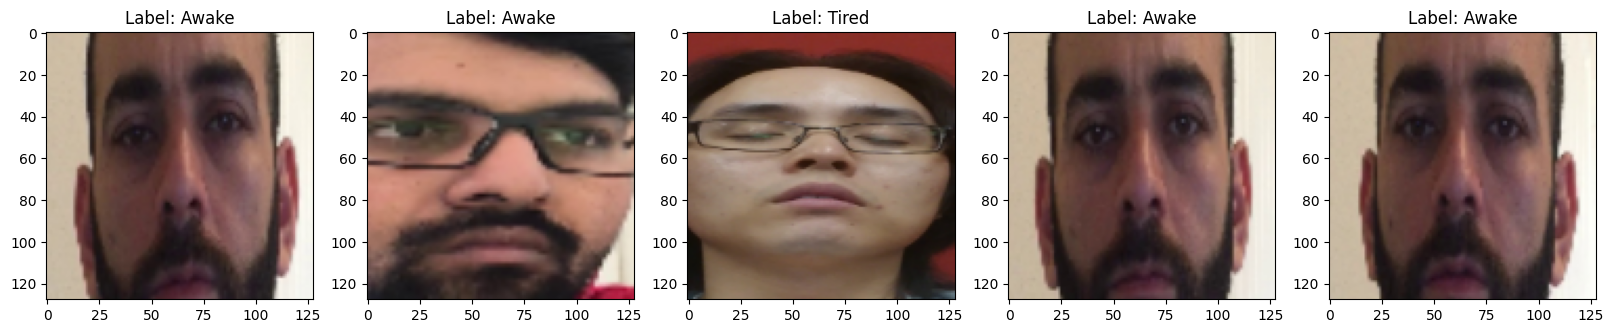

In [23]:
plot_line_of_images(X_kaggle_train_cropped, y_kaggle_train, 5)

In [24]:
# save data
# save_images(X_kaggle_train_cropped, y_kaggle_train, DIR_KAGGLE_TRAIN_DATA_CROPPED, CLASS_NAMES)

##### 6.1.3.2 Apply Haar Cascade Cropping To Our Data

In [25]:
face_cascade = load_face_cascade(HAAR_CASCADE_MODEL_PATH) 
miscropped_our_images, X_our_train_cropped = apply_haar_cascade_on_images(X_our_train, face_cascade)

print("All Test Cropped Images Shape:", X_our_train_cropped.shape)
print("All MisCropped Test Images:", miscropped_our_images)

Haar Cascade classifier loaded successfully.
All Test Cropped Images Shape: (3748, 128, 128, 3)
All MisCropped Test Images: 145


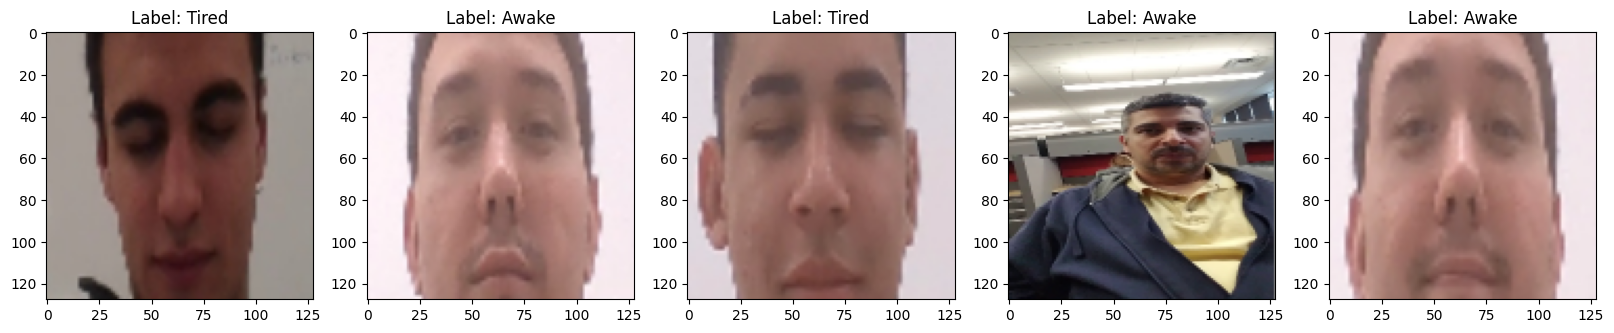

In [26]:
plot_line_of_images(X_our_train_cropped, y_our_train, 5)

In [ ]:
# save data
# save_images(X_our_train_cropped, y_our_train, DIR_OUR_TRAIN_DATA_CROPPED, CLASS_NAMES)

### 6.2 Data Augmentation

What is Data Augmentation? Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.

#### 6.2.1 Data Augmentation Constant Variables

In [27]:
DIR_KAGGLE_TRAIN_DATA_AUGMENTED = '../data/final/KaggleCroppedAugmented/'
DIR_OUR_TRAIN_DATA_AUGMENTED = '../data/final/OurCroppedAugmented/'

AUGMENTED_PERCENTAGE = 60

#### 6.2.2 Data Augmentation Utils

In [28]:
imgTrainGen = ImageDataGenerator(
    rotation_range = 50,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 15,
    zoom_range = [0.5, 1.5],
    vertical_flip = True,
    # orizontal_flip = True
)

def apply_augmentation(img):
    return imgTrainGen.random_transform(img)

#### 6.2.3 Apply Data Augmentation

##### 6.2.3.1 Apply Data Augmentation To Kaggle Data

In [29]:
# Calculate the number of elements to select
num_kaggle_augmented = int(X_kaggle_train.shape[0]*AUGMENTED_PERCENTAGE/100)
indexes_kaggle_augment = np.random.choice(X_kaggle_train.shape[0], size=num_kaggle_augmented)

In [30]:
X_kaggle_train_augmented_tmp = np.random.random((num_kaggle_augmented, CROPPED_IMAGE_SIZE[0], CROPPED_IMAGE_SIZE[1], 3))
y_kaggle_train_augmented_tmp = np.empty(num_kaggle_augmented, dtype='object')

for i, idx in enumerate(indexes_kaggle_augment):
    X_kaggle_train_augmented_tmp[i] = imgTrainGen.random_transform(X_kaggle_train_cropped[idx])
    y_kaggle_train_augmented_tmp[i] = y_kaggle_train[idx]

In [31]:
X_kaggle_train_augmented = np.concatenate([X_kaggle_train_cropped, X_kaggle_train_augmented_tmp], axis=0).astype(np.uint8)
y_kaggle_train_augmented = np.concatenate([y_kaggle_train, y_kaggle_train_augmented_tmp], axis=0)

X_kaggle_train_augmented, y_kaggle_train_augmented = shuffle(X_kaggle_train_augmented, y_kaggle_train_augmented, random_state=RANDOM_SEED)

In [32]:
print(f"The augmented array shape: {X_kaggle_train_augmented_tmp.shape}")
print(f"The original (not augmented) array shape: {X_kaggle_train_cropped.shape}")
print(f"The new array shape: {X_kaggle_train_augmented.shape}")

The augmented array shape: (2814, 128, 128, 3)
The original (not augmented) array shape: (4691, 128, 128, 3)
The new array shape: (7505, 128, 128, 3)


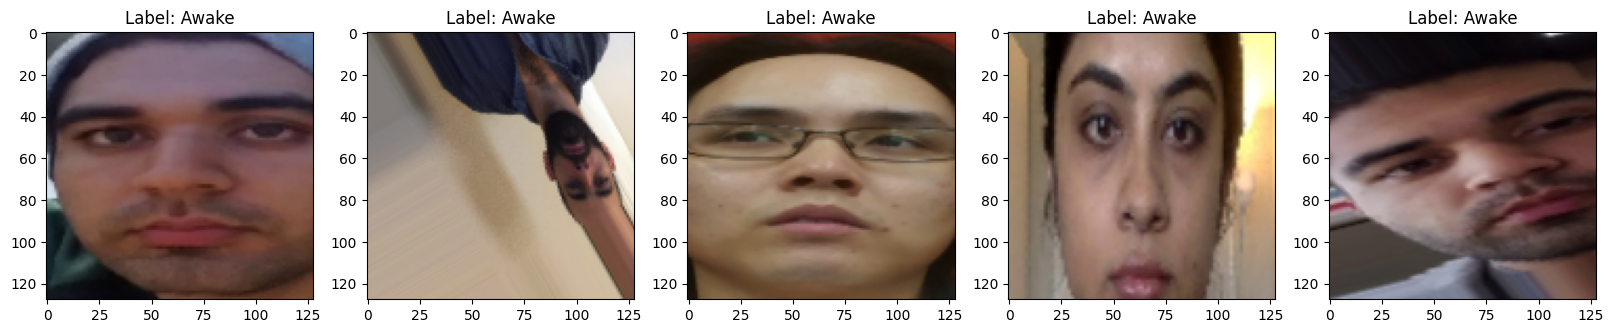

In [34]:
# plot_desired_images(X_kaggle_train_augmented, y_kaggle_train_augmented, indexes_kaggle_augment[:4])
plot_line_of_images(X_kaggle_train_augmented, y_kaggle_train_augmented, 5)

In [ ]:
# save data
# save_images(X_kaggle_train_augmented, y_kaggle_train_augmented, DIR_KAGGLE_TRAIN_DATA_AUGMENTED, CLASS_NAMES)

##### 6.2.3.2 Apply Data Augmentation To Our Data

In [35]:
# Calculate the number of elements to select
num_our_augmented = int(X_our_train.shape[0]*AUGMENTED_PERCENTAGE/100)
indexes_our_augment = np.random.choice(X_our_train.shape[0], size=num_our_augmented)

In [36]:
X_our_train_augmented_tmp = np.random.random((num_our_augmented, CROPPED_IMAGE_SIZE[0], CROPPED_IMAGE_SIZE[1], 3))
y_our_train_augmented_tmp = np.empty(num_our_augmented, dtype='object')

for i, idx in enumerate(indexes_our_augment):
    X_our_train_augmented_tmp[i] = imgTrainGen.random_transform(X_our_train_cropped[idx])
    y_our_train_augmented_tmp[i] = y_our_train[idx]

In [37]:
X_our_train_augmented = np.concatenate([X_our_train_cropped, X_our_train_augmented_tmp], axis=0).astype(np.uint8)
y_our_train_augmented = np.concatenate([y_our_train, y_our_train_augmented_tmp], axis=0)

X_our_train_augmented, y_our_train_augmented = shuffle(X_our_train_augmented, y_our_train_augmented, random_state=RANDOM_SEED)

In [38]:
print(f"The augmented array shape: {X_our_train_augmented_tmp.shape}")
print(f"The original (not augmented) array shape: {X_our_train_cropped.shape}")
print(f"The new array shape: {X_our_train_augmented.shape}")

The augmented array shape: (2248, 128, 128, 3)
The original (not augmented) array shape: (3748, 128, 128, 3)
The new array shape: (5996, 128, 128, 3)


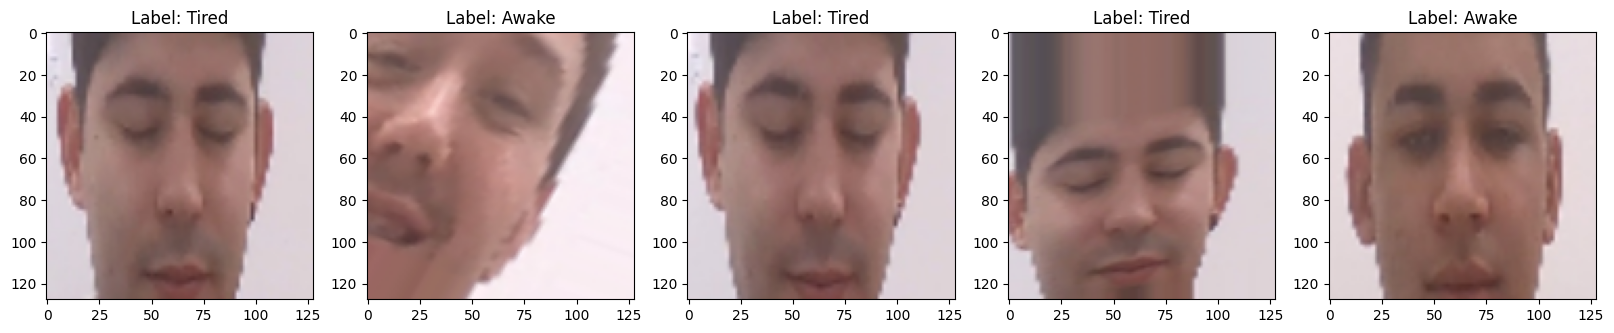

In [39]:
plot_desired_images(X_our_train_augmented, y_our_train_augmented, np.random.choice(X_our_train_augmented.shape[0], size=5))

In [ ]:
# save data
# save_images(X_our_train_augmented, y_our_train_augmented, DIR_OUR_TRAIN_DATA_AUGMENTED, CLASS_NAMES)

### 6.3 Normalization
In computer vision, the pixel normalization technique is often used to speed up model learning. The normalization of an image consists in dividing each of its pixel values by the maximum value that a pixel can take (255 for an 8-bit image, 4095 for a 12-bit image, 65 535 for a 16-bit image).

#### 6.3.1 Normalize Kaggle Data

In [40]:
X_kaggle_train_normalized = X_kaggle_train_augmented/255

#### 6.3.2 Normalize Kaggle Data

In [41]:
X_our_train_normalized = X_our_train_augmented/255

## 7 Modelling

### 7.1 Base Model
As explained on the first markdown cells, transfer learning will be used in order to improve the generalization of the model to develop. In consequence, a base model using only the data found on Kaggle will be used.

#### 7.1.1 Base Model Constant 

In [68]:
DIR_DUMP_BASE_MODEL = '../models/01BaseModel.h5'
DIR_DUMP_BASE_MODEL_WEIGHTS = '../models/01BaseModelWeights.h5'

#### 7.1.2 Create Base Model

In [69]:
BaseModelCNN2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)), # Adds a convolution layer with 32 filters of size 3x3, activated by the ReLU activation function.
    tf.keras.layers.MaxPooling2D(2, 2), # Adds a Max Pooling layer to reduce the spatial dimensionality of the convolutional layer output.
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(), # This layer flattens the output of the last convolution layer (transforming it into a one-dimensional vector) to prepare it for the densely connected layers.
    tf.keras.layers.Dropout(0.5), # Adds a Dropout layer to help prevent overfitting, randomly deactivating 50% of the neurons during training.
    tf.keras.layers.Dense(256, activation='relu'), # A dense layer with 256 neurons and ReLU activation.
    tf.keras.layers.GaussianNoise(0,1), # This layer is add to boost the eye detection
    tf.keras.layers.Dense(1, activation='sigmoid') # Output layer with a single neuron and sigmoid activation, commonly used for binary classification problems.
])

In [70]:
# Define a mapping dictionary
class_mapping = {'Awake': 0, 'Tired': 1}

# Use the mapping function to convert string labels to numerical labels
y_kaggle_train_augmented_numerical = np.array([class_mapping[label] for label in y_kaggle_train_augmented])

# Print the result
print("Original Labels:", y_kaggle_train_augmented)
print("Numerical Labels:", y_kaggle_train_augmented_numerical)

Original Labels: ['Awake' 'Awake' 'Awake' ... 'Awake' 'Tired' 'Awake']
Numerical Labels: [0 0 0 ... 0 1 0]


In [71]:
BaseModelCNN2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

history = BaseModelCNN2.fit(X_kaggle_train_normalized, y_kaggle_train_augmented_numerical, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2) 
# During the training process, in each epoch, the imgTrain generator will generate batches of augmented images and their corresponding labels to train your model. This allows the model to be trained on the dynamically augmented images at each epoch, thus improving its ability to generalize from variations of the original images.

# imgTrain: It is the data flow generator you created with data augmentation

# epochs=10: Indicates the number of times the entire training data set will be passed back and forth through the neural network during training.

# batch_size=32: Specifies the number of samples used in each training iteration. The model is updated after each batch. In this case, a lot size of 32 is used.

# validation_data=validation_set: The validation data set is provided here to evaluate the performance of the model on data not used in training. This helps monitor whether the model is overfitting or generalizing well.

Epoch 1/10
188/188 [==============================] - 41s 210ms/step - loss: 0.5756 - accuracy: 0.7129 - precision_2: 0.6435 - recall_2: 0.2819 - auc_2: 0.7095 - val_loss: 0.4837 - val_accuracy: 0.7562 - val_precision_2: 0.7483 - val_recall_2: 0.4380 - val_auc_2: 0.8196
Epoch 2/10
188/188 [==============================] - 36s 189ms/step - loss: 0.4461 - accuracy: 0.7830 - precision_2: 0.7199 - recall_2: 0.5553 - auc_2: 0.8409 - val_loss: 0.4101 - val_accuracy: 0.7928 - val_precision_2: 0.7704 - val_recall_2: 0.5659 - val_auc_2: 0.8697
Epoch 3/10
188/188 [==============================] - 35s 189ms/step - loss: 0.3841 - accuracy: 0.8140 - precision_2: 0.7687 - recall_2: 0.6202 - auc_2: 0.8829 - val_loss: 0.4036 - val_accuracy: 0.7841 - val_precision_2: 0.6486 - val_recall_2: 0.8120 - val_auc_2: 0.8890
Epoch 4/10
188/188 [==============================] - 36s 189ms/step - loss: 0.3422 - accuracy: 0.8401 - precision_2: 0.8008 - recall_2: 0.6831 - auc_2: 0.9099 - val_loss: 0.3758 - val_ac

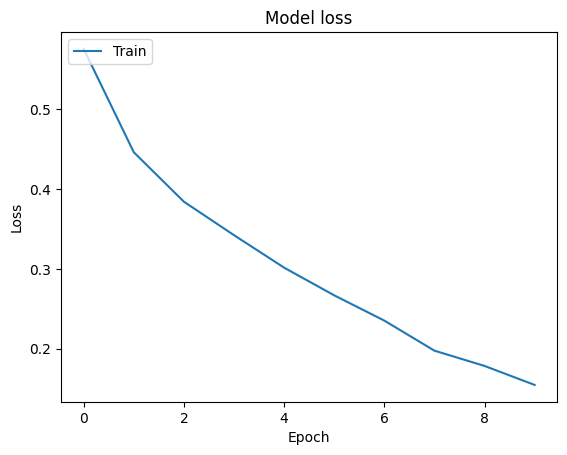

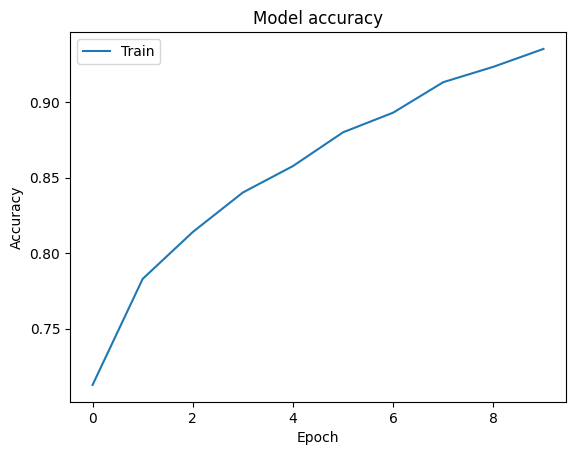

In [72]:
#Loss
plt.plot(history.history['loss']) 
#plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()
#Accuracy

plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# BaseModelCNN2.save(DIR_DUMP_BASE_MODEL)
# BaseModelCNN2.save_weights(DIR_DUMP_BASE_MODEL_WEIGHTS)

### 7.2 Cross Validation

Test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

#### 7.2.1 Cross Validation Constant Variables

In [73]:
NUM_FOLDS = 3

#### 7.2.2 Cross Validation Utils

In [74]:
def cross_validate_keras_model(model, X, y, n_splits=5, epochs=10, batch_size=32):
    """
    Perform cross-validation on a Keras model.

    Parameters:
    - model: Keras model to be cross-validated.
    - X: Input data.
    - y: Labels.
    - n_splits: Number of folds for cross-validation.
    - epochs: Number of training epochs.
    - batch_size: Batch size for training.

    Returns:
    - List of validation accuracies for each fold.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Clone the original model to ensure a fresh model for each fold
        current_model = clone_model(model)
        current_model.compile(optimizer=model.optimizer, loss=model.loss, metrics=model.metrics)

        # Define a model checkpoint to save the best model during training
        # checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

        # Train the model
        history = current_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))#, callbacks=[checkpoint])

        # Load the best model based on validation accuracy
        #current_model.load_weights(f'model_fold_{fold + 1}.h5')

        # Evaluate the model on the validation set
        _, accuracy = current_model.evaluate(X_val, y_val)
        accuracies.append(accuracy)
        print(f"Fold {fold+1}/{n_splits} - Validation Accuracy: {accuracy}")

    # Calculate and print the average accuracy across all folds
    average_accuracy = np.mean(accuracies)
    print(f"\nAverage Accuracy: {average_accuracy}")

    return accuracies

#### 7.2.3 Apply CV

In [75]:
# Define a mapping dictionary
class_mapping = {'Awake': 0, 'Tired': 1}

# Use the mapping function to convert string labels to numerical labels
y_our_train_augmented_numerical = np.array([class_mapping[label] for label in y_our_train_augmented])

# Print the result
print("Original Labels:", y_our_train_augmented)
print("Numerical Labels:", y_our_train_augmented_numerical)

Original Labels: ['Tired' 'Awake' 'Tired' ... 'Tired' 'Tired' 'Awake']
Numerical Labels: [1 0 1 ... 1 1 0]


In [76]:
# Freeze initial layers
freeze_layers = 5  # Adjust the number of layers to freeze
for layer in BaseModelCNN2.layers[:freeze_layers]:
    layer.trainable = False

In [67]:
accuracies = cross_validate_keras_model(BaseModelCNN2, X_our_train_normalized, y_our_train_augmented_numerical, n_splits=NUM_FOLDS, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10


KeyError: in user code:

    File "c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\engine\training.py", line 1154, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\optimizers\optimizer.py", line 544, in minimize
        self.apply_gradients(grads_and_vars)
    File "c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\optimizers\optimizer.py", line 1223, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\optimizers\optimizer.py", line 652, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\optimizers\optimizer.py", line 1253, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\optimizers\optimizer.py", line 1345, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\optimizers\optimizer.py", line 1342, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\optimizers\optimizer.py", line 233, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable dense/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.Adam.'


In [ ]:
# Print results
print("Mean Accuracy:", np.mean(accuracies))
print("Accuracy std:", np.std(accuracies))

Mean Accuracy: 0.9681372549019608
Accuracy std: 0.0031243992117602737


### 7.3 Final Model

#### 7.3.1 Final Model Constant Variables

In [77]:
DIR_DUMP_FINAL_MODEL = '../models/01FinalModel.h5'
DIR_DUMP_FINAL_MODEL_WEIGHTS = '../models/01FinalModelWeights.h5'

#### 7.3.2 Train The Final Model

In [78]:
BaseModelCNN2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])
final_history = BaseModelCNN2.fit(X_our_train_normalized, y_our_train_augmented_numerical, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2) 

Epoch 1/10
150/150 [==============================] - 19s 118ms/step - loss: 0.4801 - accuracy: 0.7454 - precision_3: 0.7425 - recall_3: 0.7027 - auc_3: 0.8510 - val_loss: 0.3851 - val_accuracy: 0.7817 - val_precision_3: 0.7712 - val_recall_3: 0.7602 - val_auc_3: 0.8915
Epoch 2/10
150/150 [==============================] - 15s 103ms/step - loss: 0.3224 - accuracy: 0.8267 - precision_3: 0.8360 - recall_3: 0.7860 - auc_3: 0.9281 - val_loss: 0.3424 - val_accuracy: 0.8058 - val_precision_3: 0.8327 - val_recall_3: 0.7336 - val_auc_3: 0.9211
Epoch 3/10
150/150 [==============================] - 15s 103ms/step - loss: 0.2683 - accuracy: 0.8701 - precision_3: 0.8717 - recall_3: 0.8489 - auc_3: 0.9539 - val_loss: 0.3224 - val_accuracy: 0.8325 - val_precision_3: 0.8390 - val_recall_3: 0.7957 - val_auc_3: 0.9296
Epoch 4/10
150/150 [==============================] - 15s 102ms/step - loss: 0.2139 - accuracy: 0.9026 - precision_3: 0.9010 - recall_3: 0.8910 - auc_3: 0.9732 - val_loss: 0.3333 - val_ac

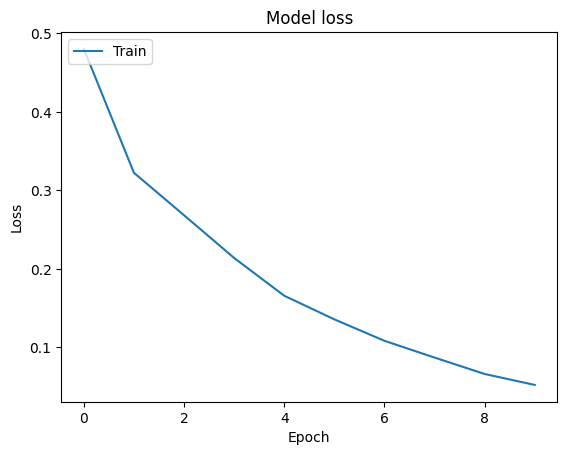

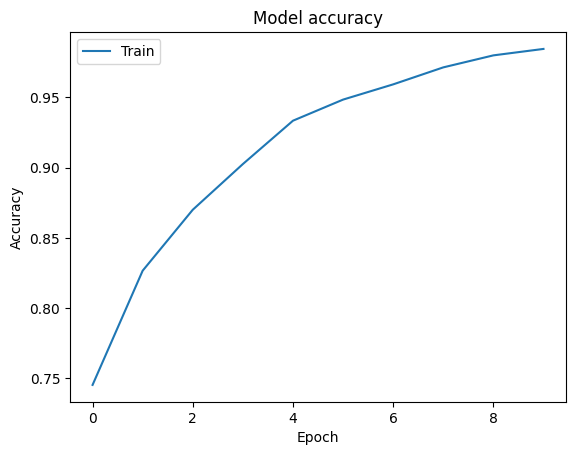

In [79]:
#Loss
plt.plot(final_history.history['loss']) 
#plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()
#Accuracy

plt.plot(final_history.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [89]:
BaseModelCNN2.save(DIR_DUMP_FINAL_MODEL)
BaseModelCNN2.save_weights(DIR_DUMP_FINAL_MODEL_WEIGHTS)

c:\Users\aritz\anaconda3\envs\neka\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 7.3 Validation

#### 7.3.1 Apply Preprocessing To Test

In [80]:
miscropped_images_test, X_test_cropped = apply_haar_cascade_on_images(X_test_shuffled, face_cascade)

print("All Test Cropped Images Shape:", X_test_cropped.shape)
print("All MisCropped Test Images:", miscropped_images_test)

All Test Cropped Images Shape: (2111, 128, 128, 3)
All MisCropped Test Images: 295


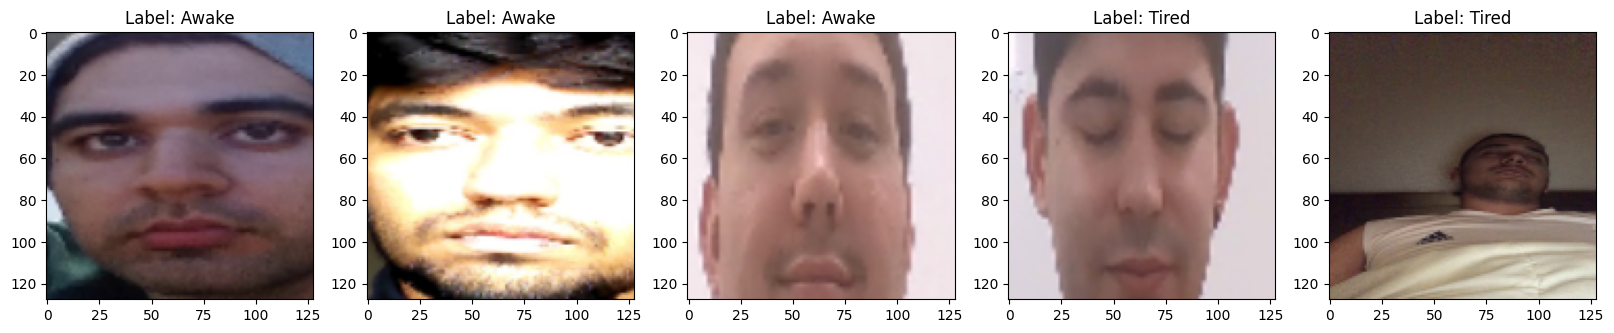

In [85]:
plot_line_of_images(X_test_cropped, y_test_shuffled, 5)

In [82]:
X_test_normalized = X_test_cropped/255

#### 7.3.2 Apply Validation

In [86]:
y_pred = BaseModelCNN2.predict(X_test_normalized)

print(np.concatenate((np.round(y_pred.reshape(len(y_pred), 1)), y_test_shuffled.reshape(len(y_test_shuffled), 1)), axis=1))

66/66 [==============================] - 3s 38ms/step
[['0.0' 'Awake']
 ['0.0' 'Awake']
 ['0.0' 'Awake']
 ...
 ['1.0' 'Awake']
 ['1.0' 'Tired']
 ['0.0' 'Awake']]


In [88]:
threshold = 0.5  # ajusta el umbral según tus necesidades
y_pred_binary = np.where(y_pred > threshold, 1, 0)


y_test_numerical = np.array([class_mapping[label] for label in y_test_shuffled])

cm = confusion_matrix(y_test_numerical, y_pred_binary)
print(cm)
accuracy = accuracy_score(y_test_numerical, y_pred_binary)
print("Accuracy:", accuracy)

[[1248   42]
 [  66  755]]
Accuracy: 0.9488394126006632
